# Documentation

**Author:** Anirudh  
**Date:** 03/04/2025  

### Modification Details:
- **Model Change:** Replacing Linear Mixed Models (LMM) with Ordinary Least Squares (OLS).
- **Predictors Update:** Including each sleep variable, ICV, Gender, and other relevant variables as predictors.
- **Outcome Update:** Separating outcomes into two categories:
    - MRI variables.
    - Cognitive test variables.
- **Variables change:** Replacing Adjusted Age to AGE

In [54]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

In [55]:
adnimerge = pd.read_csv("Imp_Files/ADNIMERGE_07Jan2024.csv")
ICV_info = adnimerge[['VISCODE','ICV','RID']]

C:\Users\anisr\AppData\Local\Temp\ipykernel_18964\879423613.py:1: DtypeWarning: Columns (19,20,21,50,51,104,105,106) have mixed types. Specify dtype option on import or set low_memory=False.
  adnimerge = pd.read_csv("Imp_Files/ADNIMERGE_07Jan2024.csv")


In [56]:
sleep_data = pd.read_csv('Longitudinal sleep.csv')
volumes_data = pd.read_csv('Volumes_merge.csv')

In [57]:
volumes_data = volumes_data.drop(['Month', 'Years_bl'],axis=1)
sleep_data.rename(columns={"VISCODE2": "VISCODE"}, inplace=True)

In [58]:
cognitive_outcomes = ['ADNI_MEM', 'ADNI_EF', 'ADNI_LAN', 'ADNI_VS', 'ADNI_EF2']
sleep_vars = ['NPIK', 'NPIKSEV', 'Sleep_Apnea', 'Restless_Legs',
              'Insomnia', 'Sleep_Disturbance_Other', 'Sleep_Quality']
mri_vars = ['Brainstem', 'CorpusCallosumAnterior', 'CorpusCallosumCentral', 'CorpusCallosumMidAnterior', 'CorpusCallosumMidPosterior', 'CorpusCallosumPosterior', 'Csf', 'RightParacentral', 'RightParahippocampal', 'RightParsOpercularis', 'RightParsOrbitalis', 'RightParsTriangularis', 'RightPericalcarine', 'RightPostcentral', 'RightPosteriorCingulate', 'RightPrecentral', 'RightPrecuneus', 'RightRostralAnteriorCingulate', 'RightRostralMiddleFrontal', 'RightSuperiorFrontal', 'RightSuperiorParietal', 'RightSuperiorTemporal', 'RightSupramarginal', 'RightTemporalPole', 'RightTransverseTemporal', 'RightUnknown', 'LeftInsula', 'RightInsula', 'LeftBankssts', 'LeftCaudalAnteriorCingulate', 'LeftCaudalMiddleFrontal', 'LeftCuneus', 'LeftEntorhinal', 'LeftFrontalPole', 'LeftFusiform', 'LeftInferiorParietal', 'LeftInferiorTemporal', 'LeftIsthmusCingulate', 'LeftLateralOccipital', 'LeftLateralOrbitofrontal', 'LeftLingual', 'LeftMedialOrbitofrontal', 'LeftMiddleTemporal', 'LeftParacentral', 'LeftParahippocampal', 'LeftParsOpercularis', 'LeftParsOrbitalis', 'LeftParsTriangularis', 'LeftPericalcarine', 'LeftPostcentral', 'LeftPosteriorCingulate', 'LeftPrecentral', 'LeftPrecuneus', 'LeftRostralAnteriorCingulate', 'LeftRostralMiddleFrontal',
            'LeftSuperiorFrontal', 'LeftSuperiorParietal', 'LeftSuperiorTemporal', 'LeftSupramarginal', 'LeftTemporalPole', 'LeftTransverseTemporal', 'LeftUnknown', 'RightBankssts', 'RightCaudalAnteriorCingulate', 'RightCaudalMiddleFrontal', 'RightCuneus', 'RightEntorhinal', 'RightFrontalPole', 'RightFusiform', 'RightInferiorParietal', 'RightInferiorTemporal', 'RightIsthmusCingulate', 'RightLateralOccipital', 'RightLateralOrbitofrontal', 'RightLingual', 'RightMedialOrbitofrontal', 'RightMiddleTemporal', 'FourthVentricle', 'Icv', 'LeftAccumbensArea', 'LeftAmygdala', 'LeftCaudate', 'LeftCerebellumCortex', 'LeftCerebellumWM', 'LeftCerebralCortex', 'LeftCerebralWM', 'LeftChoroidPlexus', 'LeftHemisphere', 'LeftHippocampus', 'LeftInferiorLateralVentricle', 'LeftLateralVentricle', 'LeftPallidum', 'LeftPutamen', 'LeftThalamus', 'LeftVentralDC', 'LeftVessel', 'NonWMHypoIntensities', 'OpticChiasm', 'RightAccumbensArea', 'RightAmygdala', 'RightCaudate', 'RightCerebellumCortex', 'RightCerebellumWM', 'RightCerebralCortex', 'RightCerebralWM', 'RightChoroidPlexus', 'RightHemisphere', 'RightHippocampus', 'RightInferiorLateralVentricle', 'RightLateralVentricle', 'RightPallidum', 'RightPutamen', 'RightThalamus', 'RightVentralDC', 'ThirdVentricle', 'WMHypoIntensities']

In [59]:
volumes_data = pd.merge(volumes_data, ICV_info, on = ['RID','VISCODE'])

In [60]:
continuous_vars = cognitive_outcomes + mri_vars
constant_vars = ['ICV', 'PTGENDER', 'Adjusted_Age','PTEDUCAT']

In [61]:
volumes_data.columns[volumes_data.isnull().any()]


Index(['DX', 'ADNI_MEM', 'ADNI_EF', 'ADNI_VS', 'ADNI_LAN', 'ADNI_EF2'], dtype='object')

In [62]:
volumes_data.at[1819, 'DX'] = 'Dementia'

In [63]:
volumes_data.fillna(method='ffill', inplace=True)

In [64]:
from sklearn.preprocessing import LabelEncoder

categorical_columns_sleep = ['Sleep_Quality','VISCODE']

label_encoders = {}

for column in volumes_data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    volumes_data[column] = le.fit_transform(volumes_data[column].astype(str))
    label_encoders[column] = le

for column in categorical_columns_sleep:
    le = LabelEncoder()
    sleep_data[column] = le.fit_transform(sleep_data[column].astype(str))
    label_encoders[column] = le

In [65]:
sleep_data['NPIKSEV'].value_counts()

-4.0    1756
 1.0     217
 2.0      94
 3.0      21
Name: NPIKSEV, dtype: int64

In [66]:
sleep_data['NPIKSEV'].replace(-4.0, 0,inplace=True)

In [67]:
corr_results_volumes = []

for cont_var in continuous_vars:
    for const_var in constant_vars:
        valid_data = volumes_data[[cont_var, const_var]].dropna()
        if not valid_data.empty:  
            corr, p_val = pearsonr(valid_data[cont_var], valid_data[const_var])
            corr_results_volumes.append({
                'Dataset': 'Volumes',
                'Continuous_Variable': cont_var,
                'Constant_Variable': const_var,
                'Correlation': corr,
                'P_Value': p_val
            })

corr_df_volumes = pd.DataFrame(corr_results_volumes)

In [68]:
corr_results_sleep = []
for sleep_var in sleep_vars:
    for const_var in constant_vars:
        corr, p_val = pearsonr(
            sleep_data[sleep_var], volumes_data[const_var])
        corr_results_sleep.append({
            'Dataset': 'Sleep',
            'Continuous_Variable': sleep_var,
            'Constant_Variable': const_var,
            'Correlation': corr,
            'P_Value': p_val
        })

corr_df_sleep = pd.DataFrame(corr_results_sleep)

In [69]:
corr_df_combined = pd.concat([corr_df_volumes, corr_df_sleep], ignore_index=True)

In [70]:
from statsmodels.stats.multitest import multipletests

corr_df_combined['FDR_P_Value'] = multipletests(
    corr_df_combined['P_Value'], method='fdr_bh')[1]

In [71]:
corr_df_combined['FWER_P_Value'] = multipletests(
    corr_df_combined['P_Value'], method='bonferroni')[1]

In [72]:
corr_df_combined.sort_values(by='FDR_P_Value', ascending=True)

,Dataset,Continuous_Variable,Constant_Variable,Correlation,P_Value,FDR_P_Value,FWER_P_Value
360,Volumes,LeftCerebralWM,ICV,0.719855,0.000000,0.000000,0.0
332,Volumes,Icv,ICV,0.999975,0.000000,0.000000,0.0
368,Volumes,LeftHemisphere,ICV,0.851524,0.000000,0.000000,0.0
436,Volumes,RightCerebralWM,ICV,0.727570,0.000000,0.000000,0.0
444,Volumes,RightHemisphere,ICV,0.857177,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...
195,Volumes,LeftParacentral,PTEDUCAT,0.003329,0.879173,0.886096,1.0
490,Sleep,NPIKSEV,Adjusted_Age,0.002206,0.919758,0.925179,1.0
155,Volumes,LeftFrontalPole,PTEDUCAT,-0.000856,0.968834,0.972634,1.0
485,Sleep,NPIK,PTGENDER,-0.000684,0.975070,0.976978,1.0


In [73]:
corr_df_combined[corr_df_combined['FDR_P_Value'] < 0.05]

,Dataset,Continuous_Variable,Constant_Variable,Correlation,P_Value,FDR_P_Value,FWER_P_Value
0,Volumes,ADNI_MEM,ICV,-0.096246,1.055212e-05,1.504926e-05,5.402684e-03
1,Volumes,ADNI_MEM,PTGENDER,-0.096763,9.453817e-06,1.352054e-05,4.840354e-03
3,Volumes,ADNI_MEM,PTEDUCAT,0.160559,1.580090e-13,3.029985e-13,8.090059e-11
4,Volumes,ADNI_EF,ICV,-0.060831,5.426797e-03,6.631313e-03,1.000000e+00
5,Volumes,ADNI_EF,PTGENDER,-0.049583,2.346875e-02,2.706306e-02,1.000000e+00
...,...,...,...,...,...,...,...
502,Sleep,Insomnia,Adjusted_Age,0.052482,1.646915e-02,1.929567e-02,1.000000e+00
503,Sleep,Insomnia,PTEDUCAT,-0.072436,9.253301e-04,1.184422e-03,4.737690e-01
506,Sleep,Sleep_Disturbance_Other,Adjusted_Age,0.060610,5.598063e-03,6.824306e-03,1.000000e+00
510,Sleep,Sleep_Quality,Adjusted_Age,-0.055442,1.128175e-02,1.352754e-02,1.000000e+00


In [74]:
corr_df_combined[corr_df_combined['FWER_P_Value'] < 0.05]

,Dataset,Continuous_Variable,Constant_Variable,Correlation,P_Value,FDR_P_Value,FWER_P_Value
0,Volumes,ADNI_MEM,ICV,-0.096246,1.055212e-05,1.504926e-05,5.402684e-03
1,Volumes,ADNI_MEM,PTGENDER,-0.096763,9.453817e-06,1.352054e-05,4.840354e-03
3,Volumes,ADNI_MEM,PTEDUCAT,0.160559,1.580090e-13,3.029985e-13,8.090059e-11
6,Volumes,ADNI_EF,Adjusted_Age,-0.087635,6.078065e-05,8.298585e-05,3.111969e-02
7,Volumes,ADNI_EF,PTEDUCAT,0.223832,4.037161e-25,9.937626e-25,2.067026e-22
...,...,...,...,...,...,...,...
480,Volumes,WMHypoIntensities,ICV,0.308521,2.772331e-47,1.006690e-46,1.419434e-44
481,Volumes,WMHypoIntensities,PTGENDER,0.117552,7.165900e-08,1.157395e-07,3.668941e-05
482,Volumes,WMHypoIntensities,Adjusted_Age,0.289872,1.052231e-41,3.567828e-41,5.387420e-39
500,Sleep,Insomnia,ICV,-0.107196,9.130639e-07,1.362941e-06,4.674887e-04


In [75]:
fdr_significant_df = corr_df_combined[corr_df_combined['FDR_P_Value'] < 0.05]
fwer_significant_df = corr_df_combined[corr_df_combined['FWER_P_Value'] < 0.05]
fdr_significant_df.to_csv('supplementary_tables/FDR_Significant_Features.csv', index=False)
fwer_significant_df.to_csv('supplementary_tables/FWER_Significant_Features.csv', index=False)

In [212]:
volumes_data.to_csv('Updated_merge.csv', index=False)
sleep_data.to_csv('Updated_sleep.csv', index=False)

In [76]:
volumes_data['ICV'].mean()

1568318.1417624522

In [77]:
(volumes_data['ICV'] > volumes_data['ICV'].mean()).sum()

1004

In [78]:
volumes_data_norm = volumes_data.copy()

high_icv_threshold = volumes_data_norm['ICV'].mean()
volumes_data_norm['High_ICV'] = volumes_data_norm['ICV'] > high_icv_threshold

mri_vars_adjusted = [var for var in mri_vars if var != 'ICV']

for var in mri_vars_adjusted:
    volumes_data_norm[f'{var}_norm'] = volumes_data_norm[var] / \
        volumes_data_norm['ICV']
volumes_data_norm.drop(columns=mri_vars_adjusted, inplace=True)

C:\Users\anisr\AppData\Local\Temp\ipykernel_18964\2757077334.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  volumes_data_norm[f'{var}_norm'] = volumes_data_norm[var] / \
C:\Users\anisr\AppData\Local\Temp\ipykernel_18964\2757077334.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  volumes_data_norm[f'{var}_norm'] = volumes_data_norm[var] / \
C:\Users\anisr\AppData\Local\Temp\ipykernel_18964\2757077334.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

In [216]:
volumes_data_norm.to_csv("supplementary_tables/Volumes_norm_ICV.csv", index=False)

In [79]:
merge_norm = pd.merge(volumes_data_norm, sleep_data, on=['RID', 'VISCODE'])

In [80]:
constant_vars = ['ICV', 'PTGENDER', 'Adjusted_Age', 'PTEDUCAT']
continuous_vars = cognitive_outcomes + sleep_vars + \
    [var for var in volumes_data_norm.columns if '_norm' in var]

correlation_results = []

for const_var in constant_vars:
    for cont_var in continuous_vars:
        valid_data = merge_norm[[const_var, cont_var]].dropna()

        if len(valid_data) > 0:
            corr_value, p_value = pearsonr(
                valid_data[const_var], valid_data[cont_var])

            correlation_results.append({
                'Constant_Var': const_var,
                'Continuous_Var': cont_var,
                'Correlation': corr_value,
                'P_Value': p_value
            })

correlation_results_df = pd.DataFrame(correlation_results)

In [81]:
correlation_results_df[
    (correlation_results_df['P_Value'] < 0.05) & (
        correlation_results_df['Correlation'].abs() >= 0.3)
]

,Constant_Var,Continuous_Var,Correlation,P_Value
12,ICV,Brainstem_norm,-0.341836,2.629554e-58
14,ICV,CorpusCallosumCentral_norm,-0.391197,2.583915e-77
15,ICV,CorpusCallosumMidAnterior_norm,-0.326109,6.256981e-53
17,ICV,CorpusCallosumPosterior_norm,-0.335544,4.061882e-56
20,ICV,RightParahippocampal_norm,-0.346377,6.434084e-60
27,ICV,RightPrecentral_norm,-0.305125,3.088152e-46
35,ICV,RightTemporalPole_norm,-0.359112,1.395170e-64
38,ICV,LeftInsula_norm,-0.312406,1.690667e-48
51,ICV,LeftLateralOrbitofrontal_norm,-0.367082,1.304463e-67
53,ICV,LeftMedialOrbitofrontal_norm,-0.341519,3.399302e-58


In [82]:
correlation_results_df[correlation_results_df['Constant_Var'] == 'ICV'].sort_values(
    by='Correlation', ascending=False).to_csv('supplementary_tables/ICV_Correlation.csv', index=False)

In [83]:
correlation_results_df[correlation_results_df['Constant_Var'].isin(
    ['PTGENDER', 'Adjusted_Age', 'PTEDUCAT'])].to_csv('supplementary_tables/Constant_Correlation.csv', index=False)

In [84]:
mri_vars = volumes_data_norm.filter(like='_norm').columns.tolist()

In [85]:
mri_outcomes = mri_vars
cognitive_outcomes = cognitive_outcomes
predictors = ['ICV', 'PTGENDER', 'AGE', 'PTEDUCAT', 'APOE4']
random_effects_var = 'RID'

In [ ]:
OLS_results_cognitive = []
OLS_results_mri = []

for sleep_var in sleep_vars:
    for outcome in cognitive_outcomes:
        try:
            formula = f"{outcome} ~ {' + '.join(predictors)} + {sleep_var}"
            model = smf.ols(formula, data=merge_norm).fit()

            for feature in predictors + [sleep_var]:
                OLS_results_cognitive.append({
                    'Outcome': outcome,
                    'Feature': feature,
                    'Coefficient': model.params[feature],
                    'P-Value': model.pvalues[feature],
                    'R-Squared': model.rsquared
                })
        except Exception as e:
            print(f"Error fitting model for {outcome} with {sleep_var}: {e}")

for sleep_var in sleep_vars:
    for outcome in mri_outcomes:
        try:
            formula = f"{outcome} ~ {' + '.join(predictors)} + {sleep_var}"
            model = smf.ols(formula, data=merge_norm).fit()

            for feature in predictors + [sleep_var]:
                OLS_results_mri.append({
                    'Outcome': outcome,
                    'Feature': feature,
                    'Coefficient': model.params[feature],
                    'P-Value': model.pvalues[feature],
                    'R-Squared': model.rsquared
                })
        except Exception as e:
            print(f"Error fitting model for {outcome} with {sleep_var}: {e}")

In [89]:
OLS_results_cognitive_df = pd.DataFrame(OLS_results_cognitive)
OLS_results_mri_df = pd.DataFrame(OLS_results_mri)

In [94]:
OLS_results_cognitive_df.groupby(['Outcome','Feature']).mean()

Coefficient       P-Value  R-Squared
Outcome  Feature                                                       
ADNI_EF  AGE                     -1.967512e-02  1.621850e-07   0.122797
         APOE4                   -3.917781e-01  1.179795e-27   0.122797
         ICV                     -4.309014e-07  1.498884e-02   0.122797
         Insomnia                 3.461408e-01  2.976032e-02   0.118688
         NPIK                    -3.167163e-01  3.003433e-08   0.129626
         NPIKSEV                 -2.836237e-01  7.541908e-12   0.136367
         PTEDUCAT                 8.394164e-02  2.322210e-23   0.122797
         PTGENDER                -7.707080e-02  2.013974e-01   0.122797
         Restless_Legs            1.705690e-01  3.778684e-01   0.117016
         Sleep_Apnea             -7.569632e-02  4.601955e-01   0.116917
         Sleep_Disturbance_Other -5.498655e-01  4.265076e-02   0.118428
         Sleep_Quality            1.221941e-01  2.004047e-04   0.122537
ADNI_EF2 AGE                     -1.694785e-02  3.352680e-06   0.109281
         APOE4                   -3.599977e-01  6.202685e-25   0.109281
         ICV                     -3.950946e-07  2.174141e-02   0.109281
         Insomnia                 2.600930e-01  9.310188e-02   0.105019
         NPIK                    -2.939856e-01  1.231978e-07   0.115773
         NPIKSEV                 -2.605557e-01  1.007677e-10   0.121634
         PTEDUCAT                 7.685234e-02  5.820668e-21   0.109281
         PTGENDER                -5.582654e-02  3.412356e-01   0.109281
         Restless_Legs            1.631691e-01  3.855805e-01   0.104129
         Sleep_Apnea             -5.889892e-02  5.544949e-01   0.103956
         Sleep_Disturbance_Other -4.465047e-01  9.048974e-02   0.105039
         Sleep_Quality            1.154750e-01  3.014527e-04   0.109414
ADNI_LAN AGE                     -1.467791e-02  5.598776e-05   0.109110
         APOE4                   -3.556967e-01  1.489890e-24   0.109110
         ICV                     -3.380142e-07  4.981306e-02   0.109110
         Insomnia                 4.437756e-01  4.092602e-03   0.103409
         NPIK                    -3.853600e-01  3.429205e-12   0.120560
         NPIKSEV                 -3.427610e-01  1.239289e-17   0.130924
         PTEDUCAT                 7.502096e-02  4.770192e-20   0.109110
         PTGENDER                -8.339065e-02  1.542650e-01   0.109110
         Restless_Legs            1.476544e-01  4.317435e-01   0.100117
         Sleep_Apnea             -7.395207e-02  4.574106e-01   0.100089
         Sleep_Disturbance_Other -3.794916e-01  1.497065e-01   0.100747
         Sleep_Quality            1.380497e-01  1.495262e-05   0.107923
ADNI_MEM AGE                     -5.656869e-03  1.432919e-01   0.137977
         APOE4                   -5.205434e-01  4.304732e-44   0.137977
         ICV                     -4.512920e-07  1.356599e-02   0.137977
         Insomnia                 2.169912e-01  1.868146e-01   0.131162
         NPIK                    -3.386071e-01  9.257893e-09   0.144115
         NPIKSEV                 -3.215385e-01  4.970497e-14   0.153830
         PTEDUCAT                 6.469238e-02  7.823702e-14   0.137977
         PTGENDER                -1.711060e-01  5.959769e-03   0.137977
         Restless_Legs           -1.240091e-01  5.343419e-01   0.130596
         Sleep_Apnea             -1.522793e-01  1.497772e-01   0.131301
         Sleep_Disturbance_Other -7.608220e-01  6.533783e-03   0.133521
         Sleep_Quality            1.732696e-01  3.081728e-07   0.141315
ADNI_VS  AGE                      1.269472e-03  6.681205e-01   0.059270
         APOE4                   -1.784139e-01  2.686312e-10   0.059270
         ICV                      1.222906e-07  3.830375e-01   0.059270
         Insomnia                 1.176357e-01  3.514407e-01   0.055335
         NPIK                    -2.077891e-01  4.577051e-06   0.064435
         NPIKSEV                 -1.883731e-01  1.003154e-08   0.069739
   

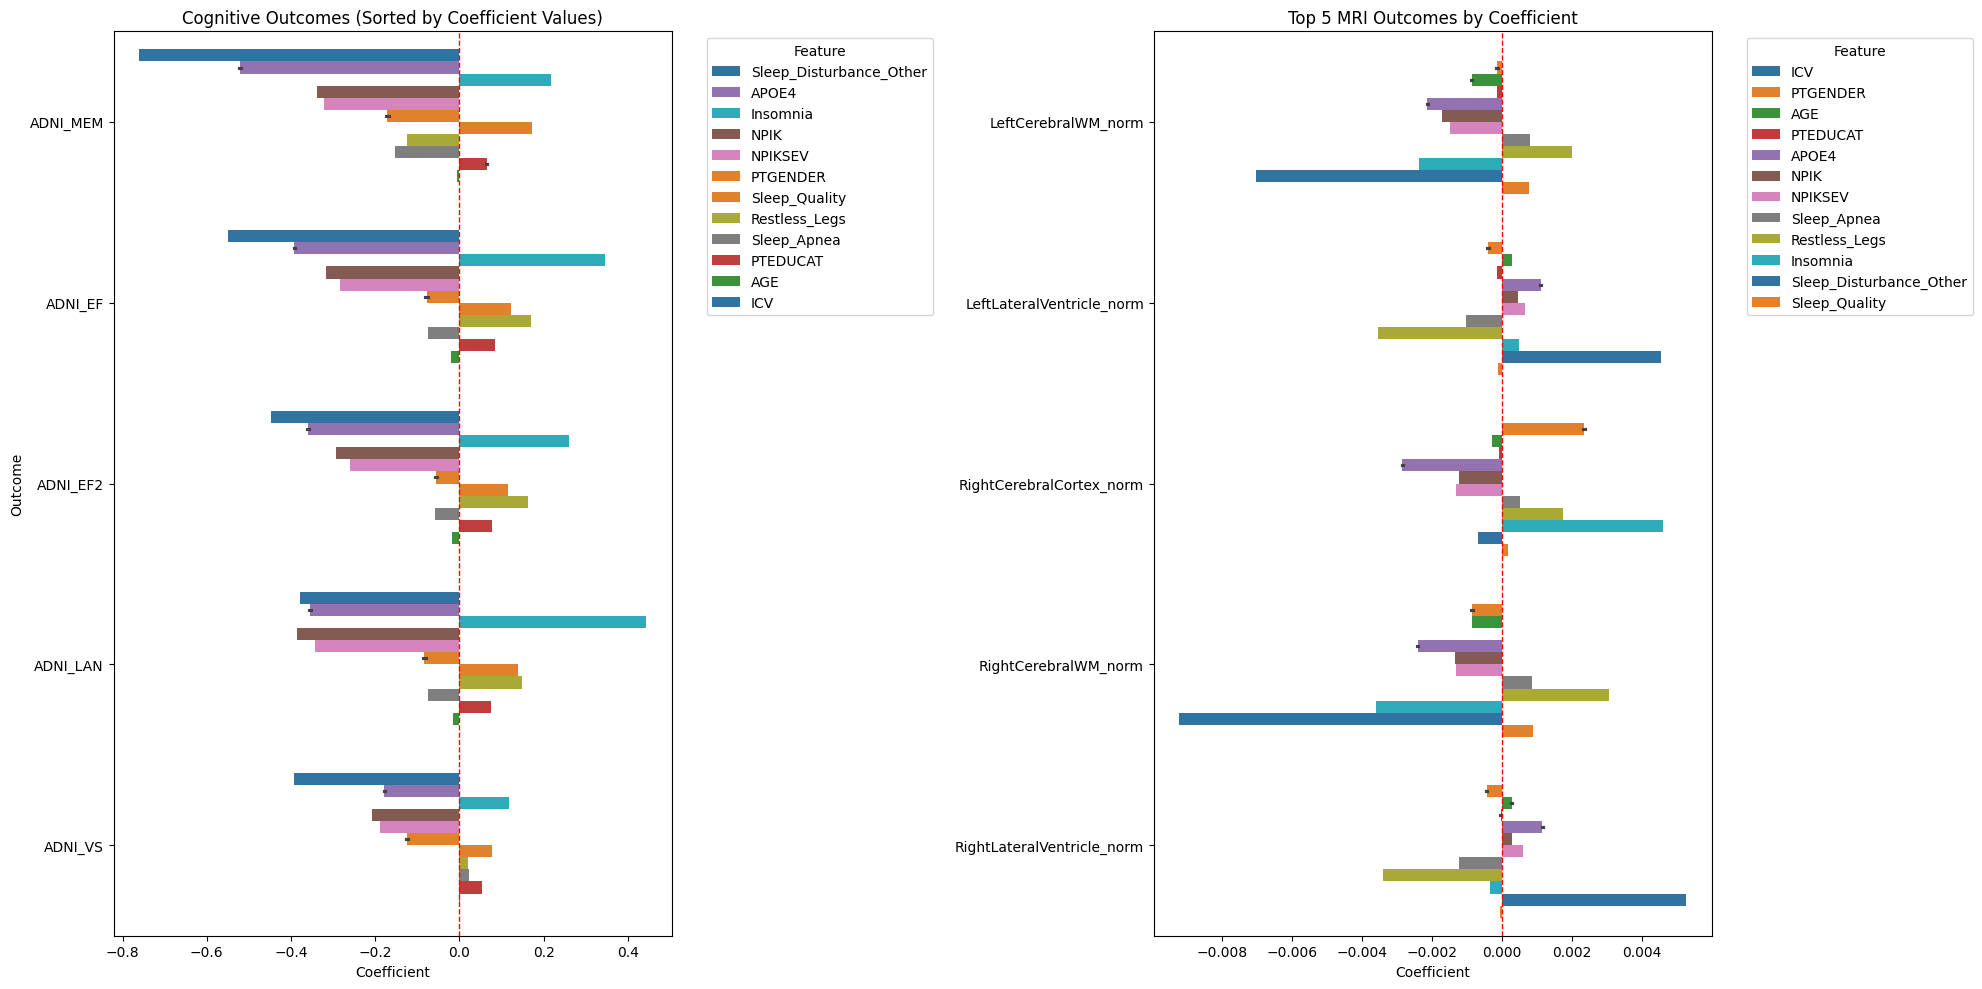

In [ ]:
OLS_results_cognitive_df['Type'] = 'Cognitive'
OLS_results_mri_df['Type'] = 'MRI'

combined_OLS_results = pd.concat(
    [OLS_results_cognitive_df, OLS_results_mri_df])

top_5_mri = (
    combined_OLS_results[combined_OLS_results['Type'] == 'MRI']
    .groupby('Outcome')['Coefficient']
    .apply(lambda x: x.abs().max())
    .nlargest(5)  
    .reset_index()
)

filtered_OLS_mri = combined_OLS_results.merge(
    top_5_mri[['Outcome']], on='Outcome')

filtered_OLS_cognitive = (
    combined_OLS_results[combined_OLS_results['Type'] == 'Cognitive']
    .sort_values(by='Coefficient', key=lambda x: x.abs(), ascending=False)
)

features = combined_OLS_results['Feature'].unique()
palette = sns.color_palette("tab10", len(features))
color_dict = dict(zip(features, palette))  

fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharey=False)

sns.barplot(
    data=filtered_OLS_cognitive,
    x='Coefficient', y='Outcome', hue='Feature', ax=axes[0],
    palette=color_dict 
)
axes[0].set_title('Cognitive Outcomes (Sorted by Coefficient Values)')
axes[0].set_xlabel('Coefficient')
axes[0].set_ylabel('Outcome')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=1)
axes[0].legend(title='Feature', bbox_to_anchor=(1.05, 1), loc='upper left')

sns.barplot(
    data=filtered_OLS_mri,
    x='Coefficient', y='Outcome', hue='Feature', ax=axes[1],
    palette=color_dict  
)
axes[1].set_title('Top 5 MRI Outcomes by Coefficient')
axes[1].set_xlabel('Coefficient')
axes[1].set_ylabel('')
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=1)
axes[1].legend(title='Feature', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig('supplementary_tables/Top_5_OLS_Coefficients_Subplots.png',
            bbox_inches='tight')
plt.show()

In [267]:
from fuzzywuzzy import fuzz, process
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

c:\Users\anisr\anaconda3\envs\research\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [286]:
sleep_data_mh = pd.read_csv('Imp_Files/RECMHIST_25Aug2023.csv')

In [288]:
sleep_data_mh['MHDESC'] = sleep_data_mh['MHDESC'].fillna(
    'Unknown').str.strip().str.lower()
mhdesc_data_ = sleep_data_mh[['RID', 'VISCODE', 'MHDESC']
                         ].drop_duplicates().reset_index(drop=True)

In [289]:
mhdesc_data_

,RID,VISCODE,MHDESC
0,2,sc,--/--/1984 pancreatitis
1,2,sc,"--/--/2001 non insulin dependent diabetes, die..."
2,2,sc,--/--/1993 cataracts removed from both eyes
3,1,f,"astigmatism ou since 1950, corrective lenses w..."
4,1,f,hepatitis a 1990
...,...,...,...
30597,363,v06,bilateral cataract extraction
30598,363,v06,constipation
30599,363,v06,word finding difficulty
30600,363,v06,short-term memory decline


In [290]:
keyword_groups = {
    "Sleep_Apnea": ["sleep apnea", "obstructive sleep apnea", "cpap", "apnea"],
    "Restless_Legs": ["restless legs", "restless leg syndrome", "rls"],
    "Insomnia": ["insomnia", "difficulty falling asleep", "trouble sleeping"],
    "Sleep_Disturbance_Other": ["circadian disorder", "sleep disturbance", "hypersomnia", "parasomnia"]
}

all_keywords = [kw for group in keyword_groups.values() for kw in group]

In [327]:
from fuzzywuzzy import fuzz, process


def fuzzy_match_with_groups(mhdesc_data, keyword_groups, threshold=60):
    matched_results = [] 

    for index, row in mhdesc_data.iterrows():
        desc = str(row['MHDESC']).lower().strip()
        best_match = None
        best_score = 0
        best_group = "No Sleep" 

        for group_name, keywords in keyword_groups.items():
            match, score = process.extractOne(
                desc, keywords, scorer=fuzz.token_sort_ratio)

            if match and score > best_score and score >= threshold:
                best_match = match
                best_score = score
                best_group = group_name

        matched_results.append({
            "RID": row['RID'],
            "VISCODE": row['VISCODE'],
            "MHDESC": row['MHDESC'],
            "Matched_Group": best_group,
            "Matched_Term": best_match if best_match else "No Match",
            "Score": best_score
        })

    matched_df = pd.DataFrame(matched_results)
    return matched_df

In [328]:
matched_ = fuzzy_match_with_groups(
    mhdesc_data_, keyword_groups, threshold=60)

Applied processor reduces input query to empty string, all comparisons will have score 0. [Query: '--']
Applied processor reduces input query to empty string, all comparisons will have score 0. [Query: '--']
Applied processor reduces input query to empty string, all comparisons will have score 0. [Query: '--']
Applied processor reduces input query to empty string, all comparisons will have score 0. [Query: '--']


In [329]:
matched_terms_df = matched_[matched_['RID'].isin(sleep_data['RID'])].sort_values(by='Score', ascending=False)


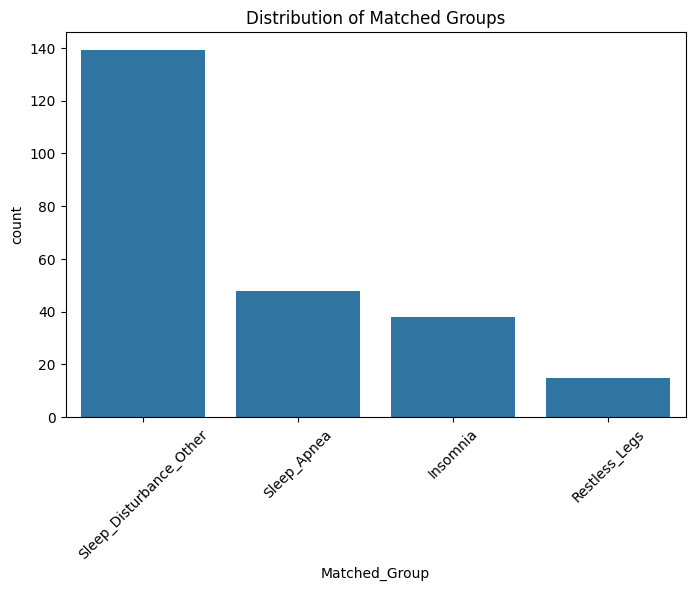

In [330]:
plt.figure(figsize=(8, 5))
filtered_df = matched_terms_df[matched_terms_df['Matched_Group'] != 'No Sleep']
sns.countplot(x='Matched_Group', data=filtered_df,
              order=filtered_df['Matched_Group'].value_counts().index)
plt.title('Distribution of Matched Groups')
plt.xticks(rotation=45)
plt.show()

In [331]:
matched_binary_df = matched_terms_df.copy()

groups = ["Sleep_Apnea", "Restless_Legs",
          "Insomnia", "Sleep_Disturbance_Other"]

for group in groups:
    matched_binary_df[group] = 0

for group in groups:
    matched_binary_df.loc[matched_binary_df['Matched_Group']
                          == group, group] = 1

In [332]:
matched_binary_df['RID'].nunique()

522

In [333]:
matched_binary_df['VISCODE'].value_counts()

sc     4603
v06    2910
m48    1369
m60     650
m36      45
Name: VISCODE, dtype: int64

In [338]:
def clean_rid_duplicates(df):
    final_rows = []

    for rid, group in df.groupby('RID'):
        matched_rows = group[group['Matched_Group'] != 'No Sleep']

        if not matched_rows.empty:
            final_rows.append(matched_rows.iloc[0])
        else:
            final_rows.append(group.iloc[0])
    cleaned_df = pd.DataFrame(final_rows).reset_index(drop=True)

    return cleaned_df

In [339]:
matched_binary_cleaned_df = clean_rid_duplicates(matched_binary_df)

In [340]:
matched_binary_cleaned_df

,RID,VISCODE,MHDESC,Matched_Group,Matched_Term,Score,Sleep_Apnea,Restless_Legs,Insomnia,Sleep_Disturbance_Other
0,3,sc,1995-hypertension; 1995-hyperlipidemia,No Sleep,No Match,0,0,0,0,0
1,5,sc,1941-rosacea,No Sleep,No Match,0,0,0,0,0
2,10,sc,2004- depressive symptoms,No Sleep,No Match,0,0,0,0,0
3,14,sc,depression in 1988. treated with antidepressan...,No Sleep,No Match,0,0,0,0,0
4,16,sc,2004 high cholesterol,No Sleep,No Match,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
517,1414,m36,one squamous cell carcinoma on face removed pr...,No Sleep,No Match,0,0,0,0,0
518,1418,v06,hypertension,Sleep_Disturbance_Other,hypersomnia,61,0,0,0,1
519,1419,m36,"l knee surgery, 1992",No Sleep,No Match,0,0,0,0,0
520,1425,v06,hypertension,Sleep_Disturbance_Other,hypersomnia,61,0,0,0,1


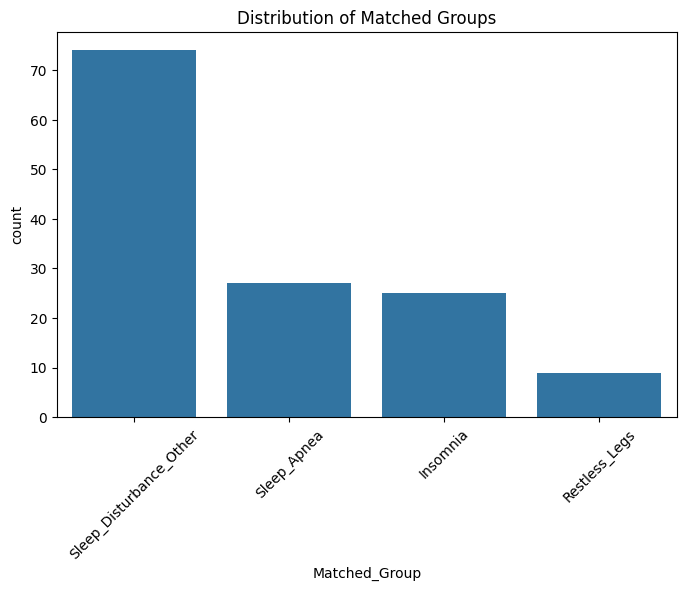

In [343]:
plt.figure(figsize=(8, 5))
filtered_df = matched_binary_cleaned_df[matched_binary_cleaned_df['Matched_Group'] != 'No Sleep']
sns.countplot(x='Matched_Group', data=filtered_df,
              order=filtered_df['Matched_Group'].value_counts().index)
plt.title('Distribution of Matched Groups')
plt.xticks(rotation=45)
plt.show()

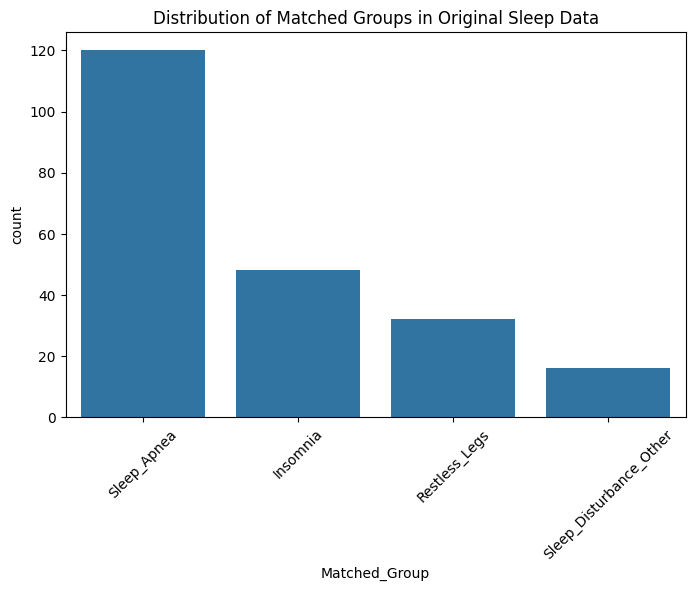

In [ ]:
sleep_groups = ['Sleep_Apnea', 'Restless_Legs',
                'Insomnia', 'Sleep_Disturbance_Other']

melted_sleep_df = sleep_data[['RID', 'VISCODE'] + sleep_groups].melt(
    id_vars=['RID', 'VISCODE'],
    value_vars=sleep_groups,
    var_name='Matched_Group',
    value_name='Presence'
)
matched_sleep_df = melted_sleep_df[melted_sleep_df['Presence'] == 1]
plt.figure(figsize=(8, 5))
sns.countplot(x='Matched_Group', data=matched_sleep_df,
              order=matched_sleep_df['Matched_Group'].value_counts().index)
plt.title('Distribution of Matched Groups in Original Sleep Data')
plt.xticks(rotation=45)
plt.show()